In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, concatenate
from keras.layers import Layer, Reshape, BatchNormalization, Activation, Input
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import RMSprop
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
import random

Using TensorFlow backend.


In [0]:
latent_dim = 100
image_size = 28
image_shape = (image_size, image_size, 1)

gen_filters = [128, 64, 32, 1]
gen_strides = [2, 2, 1, 1]

dis_filters = [32, 64, 128, 256]
dis_strides = [2, 2, 2, 1]
kernel_size = 5
strides = 2
alpha = 0.2

batch_size = 64

dis_lr = 2e-4
dis_decay = 6e-8
dis_optimizer = RMSprop(lr=dis_lr, decay=dis_decay)

adv_lr = dis_lr * 0.5
adv_decay = dis_decay * 0.5
adv_optimizer = RMSprop(lr=adv_lr, decay=adv_decay)

save_intervals = 400
train_steps = 5000
log_print_steps = 100
test_size = 100

''' Load dataset '''
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
y_train = to_categorical(y_train)
x_train = x_train.reshape((-1, image_size, image_size, 1)).astype('float32') / 255

os.makedirs('images', exist_ok=True)

In [0]:
# from IPython.display import Image

def bn_relu(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [0]:
def build_generator(z_inputs, label_inputs, image_size=28):
    filters = gen_filters
    x = concatenate([z_inputs, label_inputs])#110

    image_resize = image_size // 4

    x = Dense(image_resize * image_resize * filters[0])(x)
    x = Reshape((image_resize, image_resize, filters[0]))(x)

    for strides, filter in zip(gen_strides, filters):
        x = bn_relu(x)
        x = Conv2DTranspose(filters=filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides=strides)(x)
    outputs = Activation('tanh', name='Tanh')(x)
    model = Model([z_inputs, label_inputs], outputs, name='generator')
    # model.summary()
    plot_model(model, to_file='generator.png', show_shapes=True)
    return model


In [0]:
def build_discriminator(inputs):
    x = inputs
    # print(x.shape)
    for strides, filter in zip(dis_strides, dis_filters):
        x = LeakyReLU(alpha=alpha)(x)
        x = Conv2D(filters=filter,
                   kernel_size=kernel_size,
                   padding='same',
                   strides=strides)(x)
    y = Flatten()(x)

    x = Dense(1)(y)
    rf_outputs = Activation('sigmoid', name='Sigmoid')(x)

    c = Dense(128)(y)
    c = Dense(10)(c)
    label_outputs = Activation('softmax', name='softmax')(c)

    model = Model(inputs, [rf_outputs, label_outputs], name='discriminator')
    # model.summary()
    plot_model(model, to_file='discriminator.png', show_shapes=True)
    return model

In [0]:
def build_and_train():
    dis_inputs = Input(shape=image_shape, name='dis_inputs')
    dis = build_discriminator(dis_inputs)
    dis.compile(loss=['binary_crossentropy','categorical_crossentropy'],
                optimizer=dis_optimizer, metrics=['acc'])
    gen_z_inputs = Input(shape=(latent_dim,), name='gen_z_inputs')
    gen_label_inputs = Input(shape=(10,), name='gen_label_inputs')
    gen = build_generator(gen_z_inputs, gen_label_inputs)

    dis.trainable = False
    adv_inputs = [gen_z_inputs, gen_label_inputs]
    adv_outputs = dis(gen(adv_inputs))
    adv = Model(adv_inputs, adv_outputs, name='adverserial')
    adv.compile(loss=['binary_crossentropy','categorical_crossentropy'],
                optimizer = adv_optimizer,
                metrics=['acc'])
    # adv.summary()
    plot_model(adv, to_file='adverserial.png', show_shapes=True)
    models = gen, dis, adv
    history = train(models)
    return history

In [0]:
def train(models):
    m_train = x_train.shape[0]
    gen, dis, adv = models

    test_z = np.random.uniform(low=-1, high=1, size=[test_size, latent_dim])
    test_labels = np.eye(10)[np.arange(test_size) % 10]
    l_dis = [] 
    l_rf_dis = [] 
    acc_rf_dis = []
    l_labels_dis = [] 
    acc_labels_dis = []
    l_adv = [] 
    l_rf_adv = [] 
    acc_rf_adv = []
    l_labels_adv = []
    acc_labels_adv = []
    counter = 0
    for step in range(1, train_steps + 1):
        random_indices = np.random.randint(0, m_train, size=batch_size)
        real_images = x_train[random_indices]

        z = np.random.uniform(low=-1, high=1, size=[batch_size, latent_dim])
        fake_one_hot_labels = np.eye(10)[np.arange(batch_size) % 10]
        fake_images = gen.predict([z, fake_one_hot_labels])



        fake_rf = np.zeros((batch_size, 1))
        real_rf = np.ones((batch_size, 1))

        real_one_hot_labels = y_train[random_indices]
        fake_one_hot_labels = np.eye(10)[np.arange(batch_size) % 10]


        dis_x = np.concatenate([real_images, fake_images])
        dis_y_rf = np.concatenate([real_rf, fake_rf])
        dis_y_labels = np.concatenate([real_one_hot_labels, fake_one_hot_labels])


        l_dis1, l_rf_dis1, acc_rf_dis1, l_labels_dis1, acc_labels_dis1 = dis.train_on_batch(dis_x, [dis_y_rf, dis_y_labels])
        l_dis.append(l_dis1)
        l_rf_dis.append(l_rf_dis1)
        acc_rf_dis.append(acc_rf_dis1)
        l_labels_dis.append(l_labels_dis1)
        acc_labels_dis.append(acc_labels_dis1)

        log = f'epoch:{step} dis[loss:{l_dis1}]'

        adv_z = np.random.uniform(low=-1, high=1, size=[batch_size, latent_dim])
        adv_labels = np.eye(10)[np.arange(batch_size) % 10]
        adv_x = [adv_z, adv_labels]

        adv_y = [np.ones((batch_size, 1)), adv_labels]


        l_adv1, l_rf_adv1, acc_rf_adv1, l_labels_adv1, acc_labels_adv1 = adv.train_on_batch(adv_x, adv_y)
        l_adv.append(l_adv1)
        l_rf_adv.append(l_rf_adv1)
        acc_rf_adv.append(acc_rf_adv1)
        l_labels_adv.append(l_labels_adv1)
        acc_labels_adv.append(acc_labels_adv1)

        log += f'adv[loss:{l_adv1}]'
        counter += 1
        if counter >= log_print_steps:
            counter = 0
            print(log)
        if step % save_intervals==0:
            plot_images(gen, dis, test_z, test_labels, step, show=True)
    return l_dis, l_rf_dis, acc_rf_dis, l_labels_dis, acc_labels_dis, l_adv, l_rf_adv, acc_rf_adv, l_labels_adv, acc_labels_adv

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
def plot_images(generator, discriminator, noise_input, labels, step, show=True):
    image_address = '/content/drive/My Drive/images'
    z = noise_input
    n_images = z.shape[0]

    rows = np.sqrt(n_images)
    plt.figure(figsize=(10, 10))
    images = generator.predict([z, labels])
    _, labels = discriminator.predict(images)
    # print(labels.shape)
    labels = np.argmax(labels, axis=1)
    # print(labels)
    image_size = images.shape[1]

    for i in range(n_images):
        plt.subplot(rows, rows, i+1)
        if images.shape[3] == 1:
            plt.imshow(images[i].reshape((image_size, image_size)), cmap='gray')
            plt.title('{}'.format(class_names[labels[i]]), fontsize=9)
        else:
            plt.imshow(images[i].reshape((image_size, image_size, 1)))
            plt.title('{}'.format(labels[i]), fontsize=5)
        plt.axis('off')
    
    plt.savefig(os.path.join(image_address, f"{step}.png"))

    if show:
        plt.show()
    else:
        plt.close('all')






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:100 dis[loss:0.3870975375175476]adv[loss:0.06487378478050232]
epoch:200 dis[loss:0.8657779097557068]adv[loss:1.5084254741668701]
epoch:300 dis[loss:0.4725837707519531]adv[loss:0.1510026454925537]
epoch:400 dis[loss:0.6670689582824707]adv[loss:0.5447885394096375]


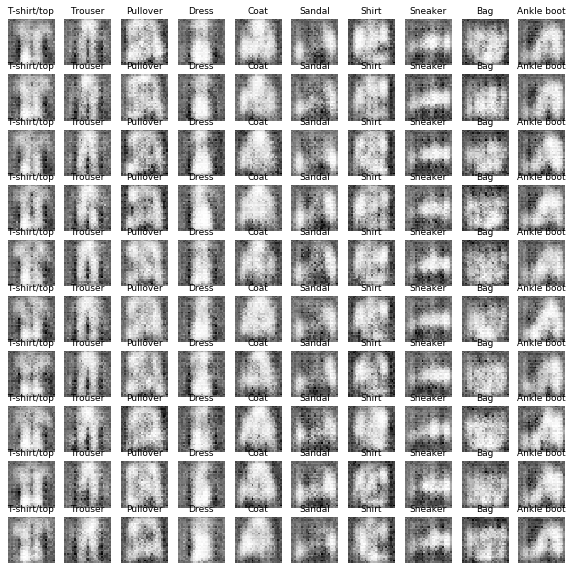

epoch:500 dis[loss:0.7437741756439209]adv[loss:0.47482797503471375]
epoch:600 dis[loss:0.5512897968292236]adv[loss:0.8082112073898315]
epoch:700 dis[loss:0.5457527041435242]adv[loss:0.6010408401489258]
epoch:800 dis[loss:0.6911511421203613]adv[loss:1.44193696975708]


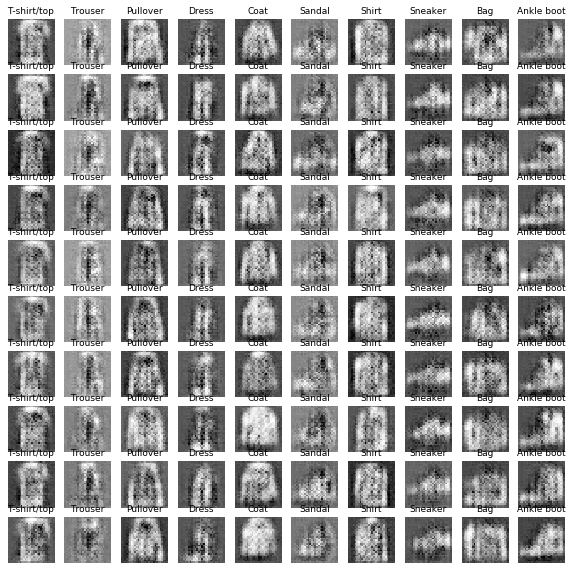

epoch:900 dis[loss:0.44711267948150635]adv[loss:1.5305207967758179]
epoch:1000 dis[loss:0.5836218595504761]adv[loss:1.9614936113357544]
epoch:1100 dis[loss:0.5998541116714478]adv[loss:1.424385905265808]
epoch:1200 dis[loss:0.6984991431236267]adv[loss:0.9613115787506104]


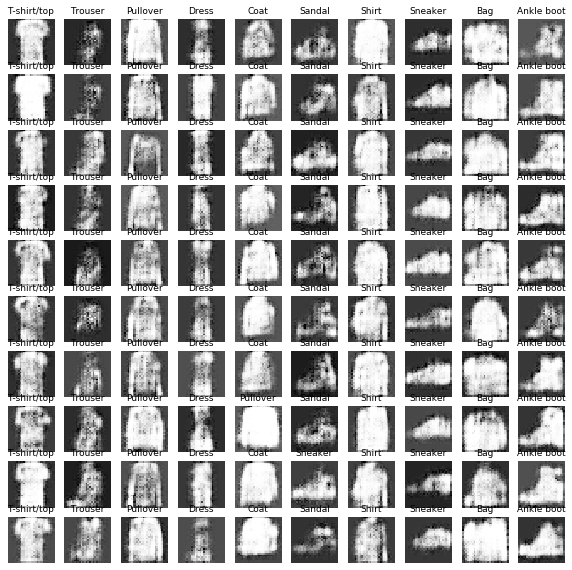

epoch:1300 dis[loss:0.7999252080917358]adv[loss:0.7556978464126587]
epoch:1400 dis[loss:0.8818929195404053]adv[loss:2.7122414112091064]
epoch:1500 dis[loss:0.7197941541671753]adv[loss:0.7898077368736267]
epoch:1600 dis[loss:0.6990090608596802]adv[loss:1.216037631034851]


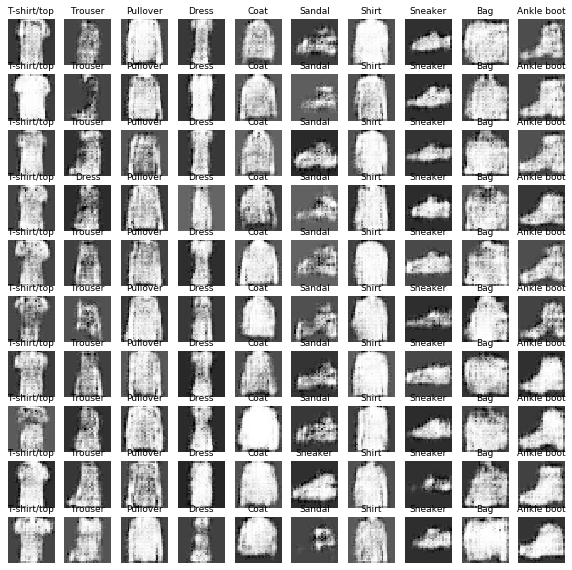

epoch:1700 dis[loss:0.6428303122520447]adv[loss:1.4989731311798096]
epoch:1800 dis[loss:0.8426408767700195]adv[loss:1.9637984037399292]
epoch:1900 dis[loss:0.6482689380645752]adv[loss:1.6658011674880981]
epoch:2000 dis[loss:0.6537913680076599]adv[loss:1.6229629516601562]


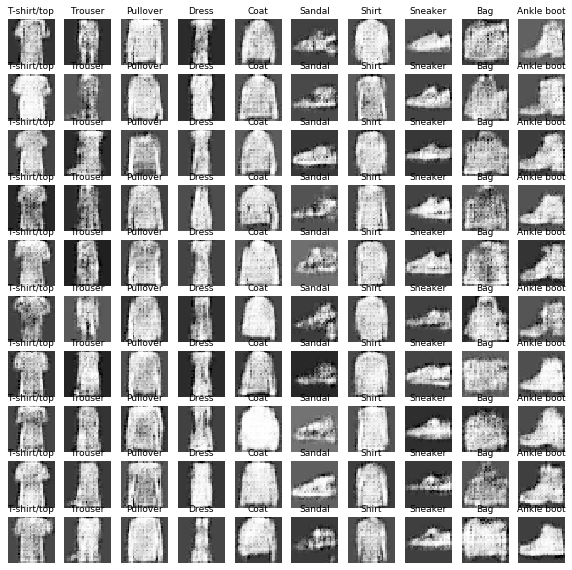

epoch:2100 dis[loss:0.6551787853240967]adv[loss:1.4795442819595337]
epoch:2200 dis[loss:0.5850633382797241]adv[loss:1.1521497964859009]
epoch:2300 dis[loss:0.5961873531341553]adv[loss:1.0899518728256226]
epoch:2400 dis[loss:0.756693422794342]adv[loss:1.8483335971832275]


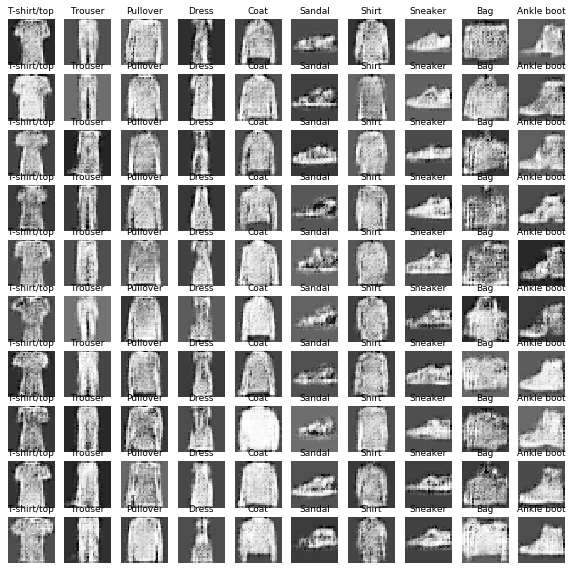

epoch:2500 dis[loss:0.7059071660041809]adv[loss:0.9042226076126099]
epoch:2600 dis[loss:0.7031639814376831]adv[loss:0.8865874409675598]
epoch:2700 dis[loss:0.7296327352523804]adv[loss:1.36150062084198]
epoch:2800 dis[loss:0.870047926902771]adv[loss:1.592161774635315]


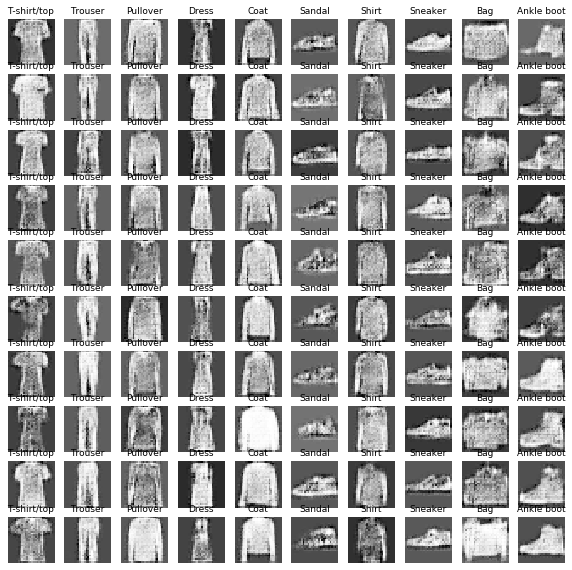

epoch:2900 dis[loss:0.7177215218544006]adv[loss:0.9186750650405884]
epoch:3000 dis[loss:0.5866268873214722]adv[loss:1.075474739074707]
epoch:3100 dis[loss:0.7526480555534363]adv[loss:1.2213174104690552]
epoch:3200 dis[loss:0.5765129327774048]adv[loss:0.9736161828041077]


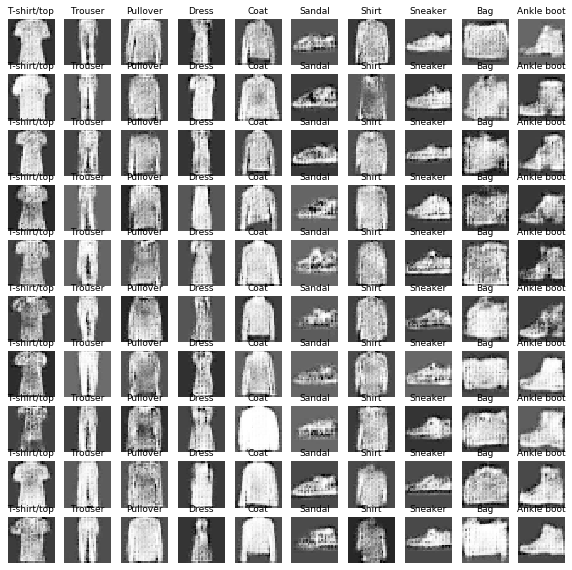

epoch:3300 dis[loss:0.6941986083984375]adv[loss:0.8246560096740723]
epoch:3400 dis[loss:0.6247196197509766]adv[loss:1.5169845819473267]
epoch:3500 dis[loss:0.6440134644508362]adv[loss:1.3031824827194214]
epoch:3600 dis[loss:0.6125543117523193]adv[loss:0.9230546951293945]


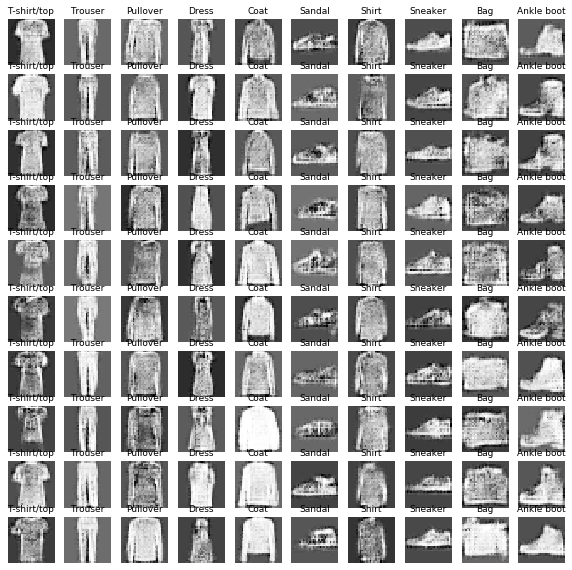

epoch:3700 dis[loss:0.7771390676498413]adv[loss:1.2288084030151367]
epoch:3800 dis[loss:0.727996826171875]adv[loss:2.0422685146331787]
epoch:3900 dis[loss:0.760455310344696]adv[loss:1.5721461772918701]
epoch:4000 dis[loss:0.7856649160385132]adv[loss:0.5795391201972961]


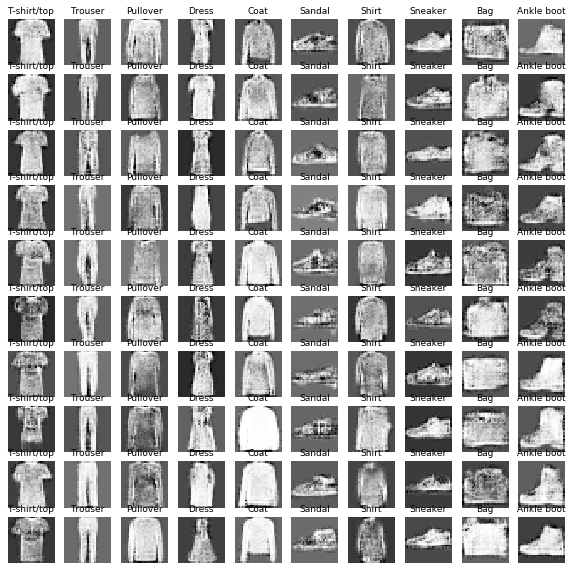

epoch:4100 dis[loss:0.6448858976364136]adv[loss:0.9407426118850708]
epoch:4200 dis[loss:1.0064034461975098]adv[loss:1.927321434020996]
epoch:4300 dis[loss:0.5730767250061035]adv[loss:0.9228903651237488]
epoch:4400 dis[loss:0.6887420415878296]adv[loss:0.9628970623016357]


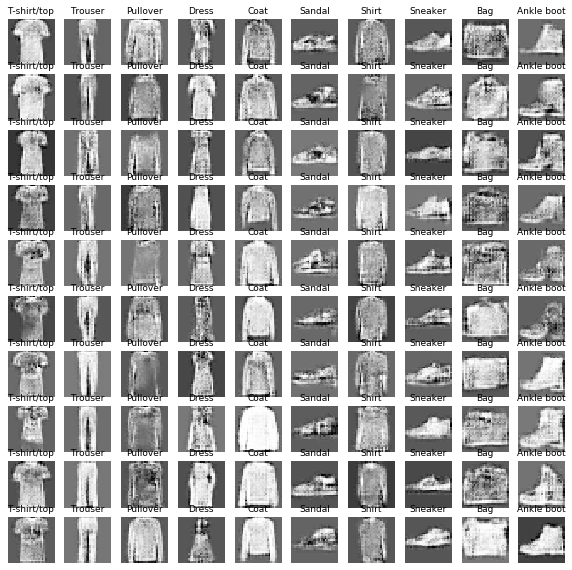

epoch:4500 dis[loss:0.5917579531669617]adv[loss:1.4293547868728638]
epoch:4600 dis[loss:0.8701562881469727]adv[loss:0.7859978675842285]
epoch:4700 dis[loss:0.5905971527099609]adv[loss:0.9963200688362122]
epoch:4800 dis[loss:0.7143337726593018]adv[loss:0.7925412058830261]


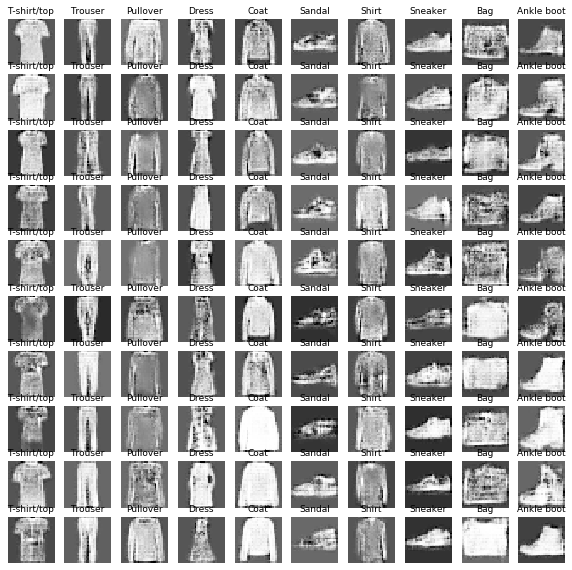

epoch:4900 dis[loss:0.7791975140571594]adv[loss:1.321774959564209]
epoch:5000 dis[loss:0.685554027557373]adv[loss:0.9899864792823792]


In [0]:
history = build_and_train()

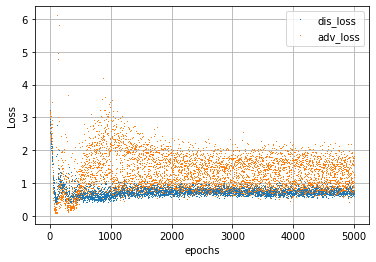

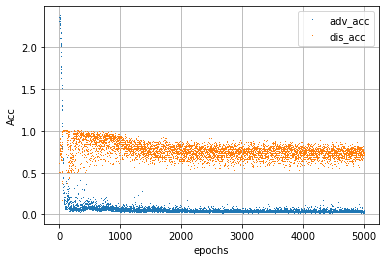

In [0]:
# l, l_rf, acc_rf, l_labels, acc_labels = history
l_dis, l_rf_dis, acc_rf_dis, l_labels_dis, acc_labels_dis, l_adv, l_rf_adv, acc_rf_adv, l_labels_adv, acc_labels_adv = history

adv_loss = np.array(l_adv)
dis_loss = np.array(l_dis)
adv_acc = np.array(acc_rf_adv)
dis_acc = np.array(l_labels_dis)

epochs = np.arange(train_steps)

''' Loss plot '''
plt.plot(epochs, dis_loss, ',', label='dis_loss')
plt.plot(epochs, adv_loss, ',', label='adv_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid('on')

''' Acc plot '''
plt.figure()
plt.plot(epochs, adv_acc, ',', label='adv_acc')
plt.plot(epochs, dis_acc, ',', label='dis_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.grid('on')